graph is flexible


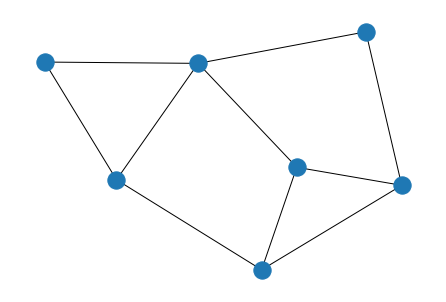

In [23]:
import networkx as nx
import itertools
from sympy import binomial
from linkages import *

def lamans_theorem(G,d):
    # run the laman comparison on the entire graph
    # condition A: if there are less than dn-bin(d+1,2) links, we call it a day and return -1 (flexible)
    # find subgraphs of miminal 3 nodes in the graph
    # if there is only one subgraph, return 0 (rigid) if there are 3 edges (a triangle) otherwise -1 (flexible) 
    # condition 1: It has exactly dn-bin(d+1,2) links and every subgraph of k joints has at most dk-bin(d+1,2) links, in other words--if we find a subgraph more than dk-bin(d+1,2) return -1 (flexible) otherwise return 0 (rigid)
    # condition 2: It has more than dn-bin(d+1,2) links and contains a generically rigid subgraph with dn-bin(d+1,2) links, in other words--if we find a subgraph of dk-bin(d+1,2) which is generically rigid return 1 (rigid) otherwise return -1 (flexible) 
    
    
def laman_comparison(G,d):
    n = G.number_of_nodes()
    e = G.number_of_edges()
    res = d*n-sy.binomial(d+1,2)
    if e < res :return -1
    if e == res:return 0
    if e > res :return 1
    
def get_subgraphs(G,k):
    subgraphs = []
    for nb_nodes in range(k, G.number_of_nodes()):  # find all subsets of k or more neighboring nodes in the graph
        for sg in (G.subgraph(selected_nodes)
            for selected_nodes in itertools.combinations(G, nb_nodes)): # select all combinations of three nodes from the graph
                if nx.is_connected(sg):subgraphs.append(sg) # if the nodes form a connected subgraph, append them to the subgraphs
    return subgraphs

graph = parallel_4_bar() # also try calling it with jensen_walker() or the braced version of either using (False,True)
nx.draw(graph)
print("graph is flexible" if lamans_theorem(graph,DIM)==-1 else "graph is rigid")
